## Imports

In [1]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T, models
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, confusion_matrix
from torchsummary import summary
import seaborn as sns
from scipy.special import softmax

import warnings
warnings.filterwarnings("ignore")


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


## Reading/Processing the Data

In [4]:
IMAGE_PATH = Path('./plant-pathology-2020-fgvc7/images')

def image_path(file_stem):
    return IMAGE_PATH/f'{file_stem}.jpg'

In [5]:
train_df = pd.read_csv('./plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('./plant-pathology-2020-fgvc7/test.csv')

train_paths = train_df['img_file'] = train_df['image_id'].apply(image_path)
test_paths = test_df['img_file'] = test_df['image_id'].apply(image_path)

train_labels = train_df[['healthy','multiple_diseases','rust','scab']]


In [33]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

### Visualize Data

In [82]:
import cv2
import imutils
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [83]:
scab = cv2.imread(str(train_df.iloc[0]['img_file']))
multi = cv2.imread(str(train_df.iloc[1]['img_file']))
rust = cv2.imread(str(train_df.iloc[1819]['img_file']))
healthy = cv2.imread(str(train_df.iloc[4]['img_file']))
kernel = np.ones((6,6),np.float32)/25

types = [healthy, multi, rust, scab]

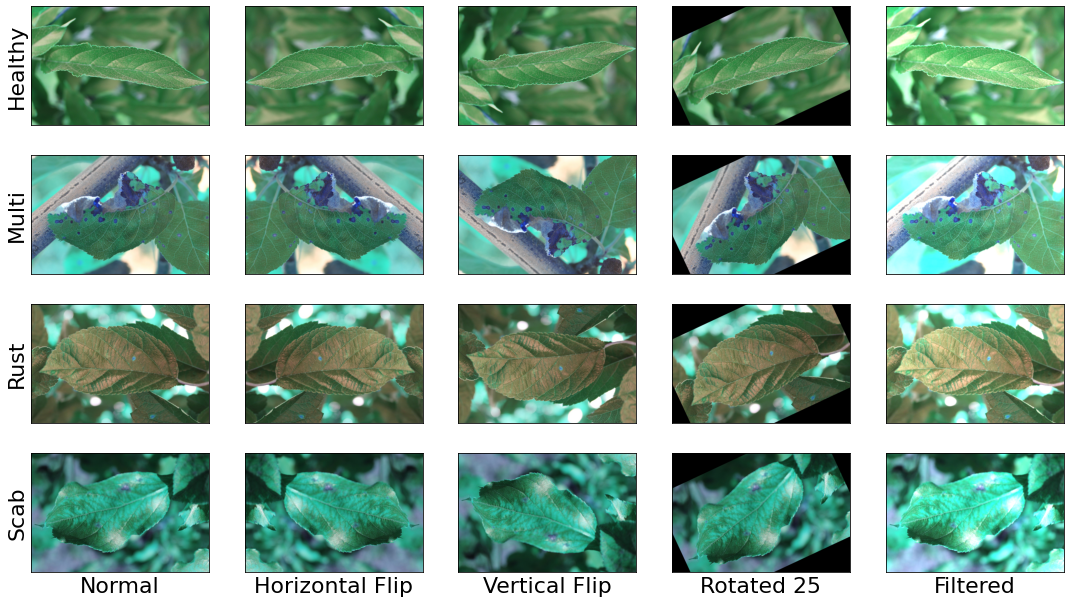

In [90]:
fig, axs = plt.subplots(4, 5)
y_labels = ['Healthy', 'Multi', 'Rust', 'Scab']
x_labels = ['Normal', 'Horizontal Flip', 'Vertical Flip', 'Rotated 25', 'Filtered']

for i in range(4):
    axs[i, 0].imshow(types[i])
    axs[i, 0].set(ylabel=y_labels[i])
    axs[i, 1].imshow(cv2.flip(types[i], 1))
    axs[i, 2].imshow(cv2.flip(types[i], 0))
    axs[i, 3].imshow(imutils.rotate(types[i], 25))
    axs[i, 4].imshow(cv2.filter2D(types[i],-1,kernel))
    
    if (i + 1) == 4:
        for j in range(5):
            axs[i, j].set(xlabel=x_labels[j])
    

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

        
fig.set_size_inches(18.5, 10.5)
fig.savefig('example.jpg')

### Creating a custom dataset object

In [7]:
class LeafDataset(Data.Dataset):
    def __init__(self, img_paths, labels=None, train=True, test=False):
        self.img_paths = img_paths
        self.train = train
        self.test = test
        
        if not self.test:
            self.labels = labels
        
        self.train_transform = T.Compose([T.RandomRotation(25),
                                          T.RandomHorizontalFlip(),
                                          T.RandomVerticalFlip(),])
        self.test_transform = T.Compose([T.RandomRotation(25),
                                         T.RandomHorizontalFlip(),
                                         T.RandomVerticalFlip(),])
        self.default_transform = T.Compose([T.ToTensor(),
                                            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]) # ImageNet Stats
        
    def __len__(self):
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, i):
        image = Image.open(self.img_paths[i]).resize((512, 512))
        if not self.test:
            label = torch.tensor(np.argmax(self.labels.loc[i, :].values))
        
        if self.train:
            image = self.train_transform(image)
        elif self.test:
            image = self.test_transform(image)
        image  = self.default_transform(image)
        
        if self.test:
            return image
        
        return image, label

### Define training, validataion and testing functions

In [8]:
def training(model, data_loader, optim, scheduler, loss_fn, acc_fn):
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total=len(data_loader), desc='Training')
    
    for idx, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        model.train()
        optim.zero_grad()
        scores = model(images)
        loss = loss_fn(scores, labels)
        loss.backward()
        optim.step()
        scheduler.step()
        
        running_loss += loss.item() * labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate(
            (preds_for_acc, np.argmax(scores.cpu().detach().numpy(), 1)), 0)
        
        pbar.update()
    
    pbar.close()
    
    return running_loss / TRAIN_SIZE, acc_fn(labels_for_acc, preds_for_acc)


def validation(model, data_loader, loss_fn, acc_fn, confusion_matrix):
     
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(data_loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            model.eval()
            scores = model(images)
            loss = loss_fn(scores, labels)
            
            running_loss += loss.item() * labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(scores.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = acc_fn(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat


def testing(model, data_loader):
    
    preds_for_output = np.zeros((1,4))
    
    with torch.no_grad():
        pbar = tqdm(total = len(data_loader))
        for _, images in enumerate(data_loader):
            images = images.to(device)
            model.eval()
            scores = model(images)
            preds_for_output = np.concatenate((preds_for_output, scores.cpu().detach().numpy()), 0)
            pbar.update()
    
    pbar.close()
    return preds_for_output

### Initialization

In [9]:
BATCH_SIZE = 8
NUM_EPOCHS = 30
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]

In [10]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths,train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

#### Please only run one of the net sections before running the training loop

### DenseNet

In [11]:
densenet = models.densenet161(pretrained=True)
model = densenet

In [12]:
num_filters = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Linear(num_filters, train_labels.shape[1])
)

In [13]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### ResNet

In [ ]:
resnet18 = models.resnet18(pretrained=True)
num_filters = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_filters, train_labels.shape[1])
model = resnet18

In [ ]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### Inception

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### Training loop

In [14]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = training(model, trainloader, optimizer, scheduler, loss_fn, accuracy_score)
    vl, va, conf_mat = validation(model, validloader, loss_fn, accuracy_score, confusion_matrix)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        checkpoint = Path('model_checkpoints/')
        checkpoint.mkdir(exist_ok=True)
        torch.save(model.state_dict(), checkpoint/f'epoch_{epoch}.pt')
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    


Epoch: 0, Train loss: 0.6909544145749821, Val loss: 0.5987489458632795, Train acc: 0.742445054945055, Val acc: 0.852054794520548



Epoch: 1, Train loss: 0.40659791214780494, Val loss: 0.40211752114230637, Train acc: 0.8743131868131868, Val acc: 0.8493150684931506



Epoch: 2, Train loss: 0.41054222462596474, Val loss: 0.2575851365311505, Train acc: 0.8784340659340659, Val acc: 0.915068493150685



Epoch: 3, Train loss: 0.48971174911155807, Val loss: 0.4716689506213959, Train acc: 0.8571428571428571, Val acc: 0.8465753424657534



Epoch: 4, Train loss: 0.4473004549905494, Val loss: 0.5082001186396977, Train acc: 0.8681318681318682, Val acc: 0.8136986301369863



Epoch: 5, Train loss: 0.5227710998074694, Val loss: 0.707156532431302, Train acc: 0.8434065934065934, Val acc: 0.7342465753424657



Epoch: 6, Train loss: 0.44872604224544305, Val loss: 0.34130522404631525, Train acc: 0.8578296703296703, Val acc: 0.8986301369863013



Epoch: 7, Train loss: 0.4344392637466336, Val loss: 0.2420400624405848, Train acc: 0.8804945054945055, Val acc: 0.9205479452054794



Epoch: 8, Train loss: 0.39393314330296203, Val loss: 0.2819421741243911, Train acc: 0.8777472527472527, Val acc: 0.915068493150685



Epoch: 9, Train loss: 0.4220242476561567, Val loss: 0.4869296408679387, Train acc: 0.8763736263736264, Val acc: 0.810958904109589



Epoch: 10, Train loss: 0.3610767368022557, Val loss: 0.3601415850528299, Train acc: 0.8928571428571429, Val acc: 0.8958904109589041



Epoch: 11, Train loss: 0.368915319115251, Val loss: 0.36187289283700186, Train acc: 0.8942307692307693, Val acc: 0.8794520547945206



Epoch: 12, Train loss: 0.34412921617155545, Val loss: 0.25553157690861455, Train acc: 0.8935439560439561, Val acc: 0.9287671232876712



Epoch: 13, Train loss: 0.3272254052316094, Val loss: 0.22104155176306425, Train acc: 0.9024725274725275, Val acc: 0.9287671232876712



Epoch: 14, Train loss: 0.3169900679571943, Val loss: 0.23422666298200007, Train acc: 0.9127747252747253, Val acc: 0.9232876712328767



Epoch: 15, Train loss: 0.30002769790999184, Val loss: 0.23493919690994367, Train acc: 0.9086538461538461, Val acc: 0.9342465753424658



Epoch: 16, Train loss: 0.30980464816093445, Val loss: 0.18159665081598989, Train acc: 0.9004120879120879, Val acc: 0.9342465753424658



Epoch: 17, Train loss: 0.2542767013003538, Val loss: 0.22769365751580017, Train acc: 0.9196428571428571, Val acc: 0.9205479452054794



Epoch: 18, Train loss: 0.2769343395318304, Val loss: 0.24034412446087353, Train acc: 0.9196428571428571, Val acc: 0.9260273972602739



Epoch: 19, Train loss: 0.21554959815118338, Val loss: 0.1689934100190254, Train acc: 0.9292582417582418, Val acc: 0.9342465753424658



Epoch: 20, Train loss: 0.20706218423751685, Val loss: 0.17162748101639422, Train acc: 0.9429945054945055, Val acc: 0.9315068493150684



Epoch: 21, Train loss: 0.19936646537466363, Val loss: 0.1542028539801297, Train acc: 0.9375, Val acc: 0.9506849315068493



Epoch: 22, Train loss: 0.19294789883789126, Val loss: 0.14643939047643584, Train acc: 0.9395604395604396, Val acc: 0.947945205479452



Epoch: 23, Train loss: 0.17334663376703366, Val loss: 0.1818629754732733, Train acc: 0.9478021978021978, Val acc: 0.9452054794520548



Epoch: 24, Train loss: 0.1505904147340046, Val loss: 0.16798586371826799, Train acc: 0.9491758241758241, Val acc: 0.9397260273972603



Epoch: 25, Train loss: 0.1298683781872739, Val loss: 0.14381654899414273, Train acc: 0.9601648351648352, Val acc: 0.9561643835616438



Epoch: 26, Train loss: 0.1265303104051522, Val loss: 0.14490213900396268, Train acc: 0.9608516483516484, Val acc: 0.958904109589041



Epoch: 27, Train loss: 0.1065756816130418, Val loss: 0.1363474971627536, Train acc: 0.967032967032967, Val acc: 0.9561643835616438



Epoch: 28, Train loss: 0.11204547983604474, Val loss: 0.1451264108697029, Train acc: 0.9649725274725275, Val acc: 0.9534246575342465



Epoch: 29, Train loss: 0.10925039182324986, Val loss: 0.1357838454311841, Train acc: 0.9690934065934066, Val acc: 0.9561643835616438


### Plots

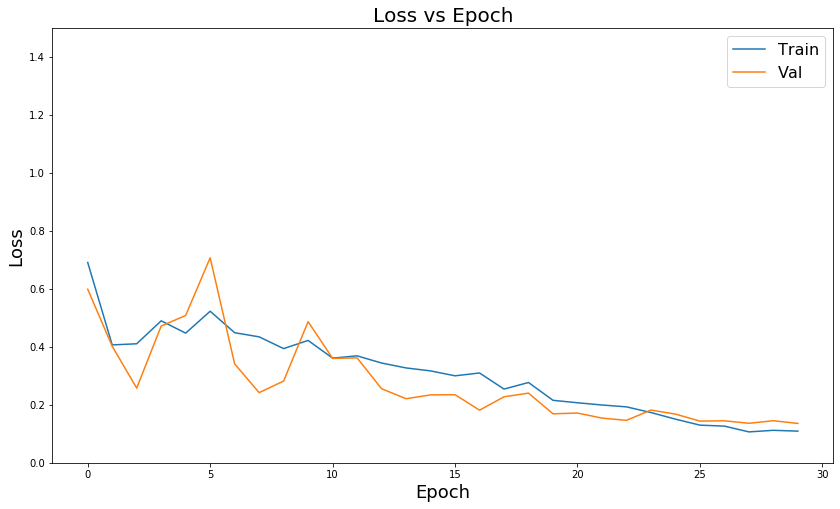

In [24]:
plt.figure(figsize=(14, 8))
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(['Train','Val'], fontsize=16)
plt.title('Loss vs Epoch', fontsize=20)
plt.savefig('densenet_loss.jpg')

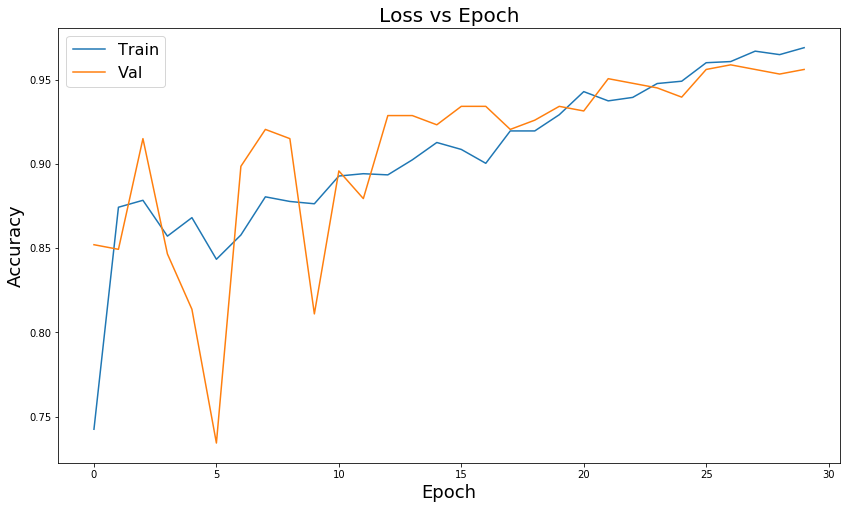

In [26]:
plt.figure(figsize=(14, 8))
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend(['Train','Val'], fontsize=16)
plt.title('Loss vs Epoch', fontsize=20)
plt.savefig('densenet_accuracy.jpg')

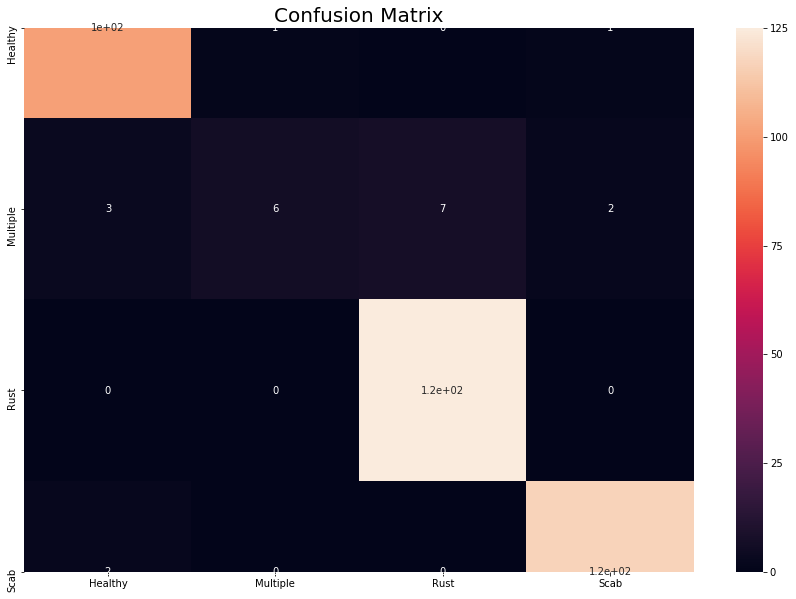

In [34]:
labels = ['Healthy', 'Multiple','Rust','Scab']
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
plt.title('Confusion Matrix', fontsize=20)
plt.savefig('confusion.jpg')

### Testing Performance

In [ ]:
subs = []
for i in range(5): #average over 5 runs
    out = testing(model, testloader)
    output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
    output.drop(0, inplace = True)
    output.reset_index(drop=True,inplace=True)
    subs.append(output)

sub_eff1 = sum(subs)/5

### Model Emsembling